In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
import json

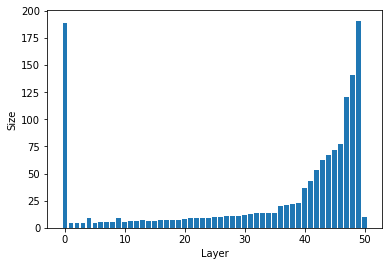

In [2]:
df_org = pd.read_csv('./LayersfcosOriginal.csv')
plt.ylabel("Size")
plt.xlabel("Layer")
plt.bar([i for i in range(len(df_org))][:], df_org['SIZE'][:])
plt.rcParams["figure.figsize"] = (10, 10)

### Raw Data Visualization

Average size maxmin 335825.09523809527
Average freq maxmin 4.220551378446116


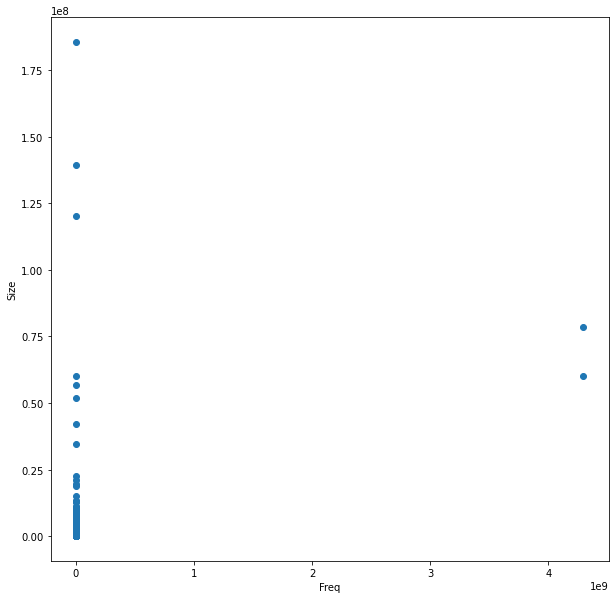

In [3]:
df_pre = pd.read_csv('./parsed/metaFromFcos36.20221024.20.0.csv')
print("Average size maxmin",sum(df_pre["Size"][65:])/len(df_pre["Size"]))
print("Average freq maxmin",sum(df_pre["Frequency"][65:])/len(df_pre["Frequency"]))
plt.ylabel("Size")
plt.xlabel("Freq")
plt.scatter(df_pre['Frequency'], df_pre['Size'])

In [6]:
zero= 0
size = 0
for i, freq in enumerate(df_pre["Frequency"]):
    if freq == 1:
        zero += 1
        size += df_pre["Size"][i]
print(size, zero)

print(df_pre[])

27838375 54
                                                  Name   Frequency       Size  \
0              linux-firmware-20221012-141.fc36.noarch          18  185645836   
1                       containerd-1.6.8-4.fc36.x86_64          17  139347468   
2                   moby-engine-20.10.20-1.fc36.x86_64          14  120061594   
3           initramfs (kernel 5.19.16-200.fc36.x86_64)  4294967295   78644624   
4                         rpmostree-unpackaged-content  4294967295   60198062   
..                                                 ...         ...        ...   
394  console-login-helper-messages-profile-0.21.3-1...           2        728   
395              nano-default-editor-6.0-2.fc36.noarch           2        272   
396                         setup-2.14.1-1.fc36.noarch           2        178   
397                samba-common-2:4.16.5-0.fc36.noarch          28         28   
398                      filesystem-3.18-2.fc36.x86_64           3          0   

               

Since there exists freq with MAX_INT, we will group them in one and treat them as separate and hence not include them as a part of this analysis

In [48]:
rust_u32_int_max = 4294967295
max_freq_row_no = []
for i, val in enumerate(df_pre['Frequency']):
    if val == rust_u32_int_max:
        max_freq_row_no.append(i)
df = df_pre.drop(max_freq_row_no).sort_values(by=['Frequency']).reset_index(drop=True)
print("Available: ", len(df_pre))

Available:  399


<BarContainer object of 397 artists>

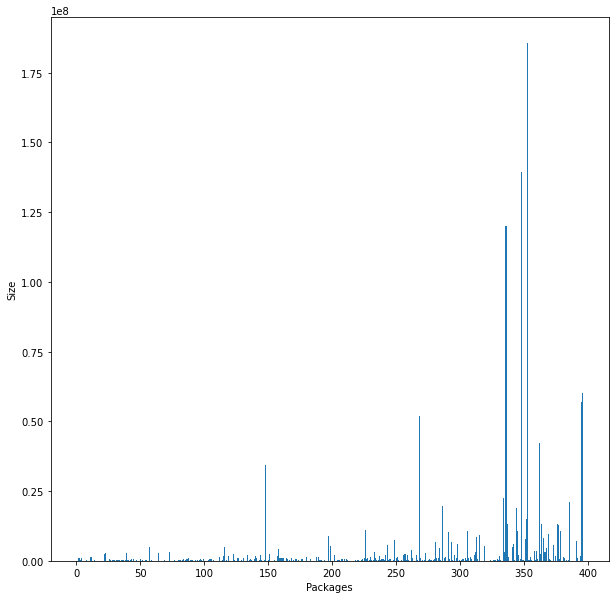

In [49]:
plt.ylabel("Size")
plt.xlabel("Packages")
# plt.bar([i for i in range(len(df_pre))][:], df_pre["Size"][:])
plt.bar([i for i in range(len(df))][:], df["Size"][:])

### Clipped Data Visualization

s_low:  0.0 , s_hi:  185645836.0
f_low:  0.0 , f_hi:  120.0
Ignored: 0
Anomalitites Ignored 0.0 %


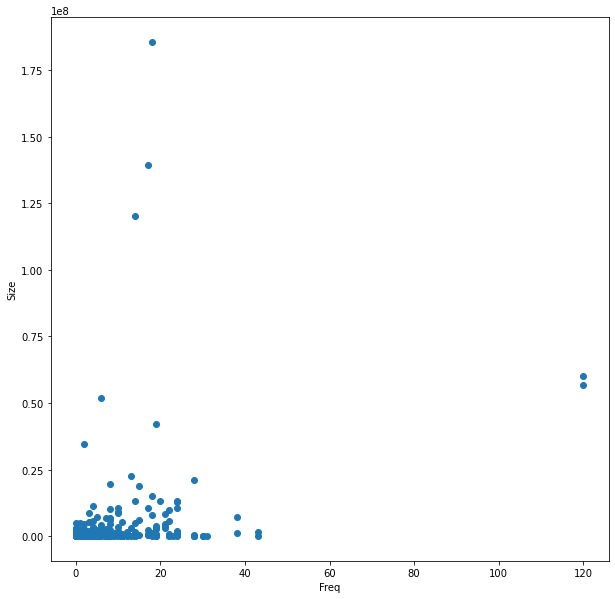

In [50]:
plt.ylabel("Size")
plt.xlabel("Freq")
s_low = df["Size"].quantile(0)
s_hi  = df["Size"].quantile(1)
f_low = df["Frequency"].quantile(0)
f_hi  = df["Frequency"].quantile(1)
print("s_low: ", s_low, ", s_hi: ", s_hi)
print("f_low: ", f_low, ", f_hi: ", f_hi)
proc = df[(df["Frequency"] <= f_hi) & (df["Frequency"] >= f_low) & (df["Size"] <= s_hi) & (df["Size"] >= s_low)]
plt.scatter(proc["Frequency"], proc["Size"])
print("Ignored:", len(df['Size']) - len(proc['Size']))
print("Anomalitites Ignored", (1-((len(proc['Size']))/len(df['Size'])))*100, "%")

### Frequency Analysis

### Finding Anomalies using Stat

In [52]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def outliers(col, data, threshold):
    low_limit = 0
    if col == "Frequency":
        low_limit = 1
    else:
        low_limit = 10
    mean = df[col].mean()
    std = df[col].std()
    threshold = threshold
    high_outlier = []
    low_outlier = []
    for i, val in enumerate(data[col]):
        if val >= mean + threshold*std:
            high_outlier.append(data["Name"][i])
        if val <= low_limit:
            low_outlier.append(data["Name"][i])
    return [high_outlier, low_outlier]

def mid(col, data, threshold):
    low_limit = 0
    if col == "Frequency":
        low_limit = 0
    else:
        low_limit = 10
    mean = df[col].mean()
    std = df[col].std()
    threshold = threshold
    mid = []
    for i, val in enumerate(data[col]):
        if val < mean + threshold*std and val > low_limit:
            mid.append(data["Name"][i])
    return mid

def map_pkg(df, pkgs):
    f_map = []
    s_map = []
    n_map = []
    for i, val in enumerate(df["Name"]):
        if val in pkgs:
            n_map.append(df["Name"][i])
            f_map.append(df["Frequency"][i])
            s_map.append(df["Size"][i])
    return [f_map, s_map, n_map]

def maxmin(arr):
    if len(arr) != 0:
        return max(arr) - min(arr)
    else:
        return "Nan"
      
    

In [53]:
h_out_freq = outliers("Frequency", df, 1.5)[0]
h_out_size = outliers("Size", df, 1.5)[0]
l_out_freq = outliers("Frequency", df, 1.5)[1]
l_out_size = outliers("Size", df, 1.5)[1]
mid_freq = mid("Frequency", df, 1.5)
mid_size = mid("Size", df, 1.5)

lf_hs = intersection(h_out_size, l_out_freq)
mf_hs = intersection(h_out_size, mid_freq)
hf_hs = intersection(h_out_freq, h_out_size)
lf_ms = intersection(mid_size, l_out_freq)
mf_ms = intersection(mid_size, mid_freq)
hf_ms = intersection(h_out_freq, mid_size)
lf_ls = intersection(l_out_freq, l_out_size)
mf_ls = intersection(mid_freq, l_out_size)
hf_ls = intersection(h_out_freq, l_out_size)

print("lf_hs:", len(lf_hs), "which is", round(len(lf_hs)/len(df['Size'])*100, 1), "% of total pkgs")
print("mf_hs:", len(mf_hs), "which is", round(len(mf_hs)/len(df['Size'])*100, 1), "% of total pkgs")
print("hf_hs:", len(hf_hs), "which is", round(len(hf_hs)/len(df['Size'])*100, 1), "% of total pkgs")
print("lf_ms:", len(lf_ms), "which is", round(len(lf_ms)/len(df['Size'])*100, 1), "% of total pkgs")
print("mf_ms:", len(mf_ms), "which is", round(len(mf_ms)/len(df['Size'])*100, 1), "% of total pkgs")
print("hf_ms:", len(hf_ms), "which is", round(len(hf_ms)/len(df['Size'])*100, 1), "% of total pkgs")
print("lf_ls:", len(lf_ls), "which is", round(len(lf_ls)/len(df['Size'])*100, 1), "% of total pkgs")
print("mf_ls:", len(mf_ls), "which is", round(len(mf_ls)/len(df['Size'])*100, 1), "% of total pkgs")
print("hf_ls:", len(hf_ls), "which is", round(len(hf_ls)/len(df['Size'])*100, 1), "% of total pkgs")

lf_hs: 0 which is 0.0 % of total pkgs
mf_hs: 6 which is 1.5 % of total pkgs
hf_hs: 2 which is 0.5 % of total pkgs
lf_ms: 135 which is 34.0 % of total pkgs
mf_ms: 287 which is 72.3 % of total pkgs
hf_ms: 20 which is 5.0 % of total pkgs
lf_ls: 0 which is 0.0 % of total pkgs
mf_ls: 1 which is 0.3 % of total pkgs
hf_ls: 0 which is 0.0 % of total pkgs


Total Size of lf_hs 0 Frequency difference: Nan
Total Size of mf_hs 573651207 Frequency difference: 17
Total Size of hf_hs 116977038 Frequency difference: 0
Total Size of lf_ms 61906100 Frequency difference: 1
Total Size of mf_ms 429048422 Frequency difference: 22
Total Size of hf_ms 72991218 Frequency difference: 19
Total Size of lf_ls 0 Frequency difference: Nan
Total Size of mf_ls 0 Frequency difference: 0
Total Size of hf_ls 0 Frequency difference: Nan


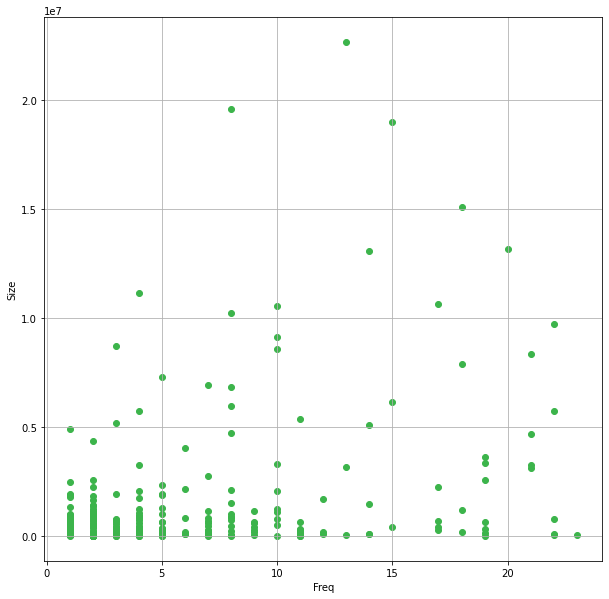

In [58]:
plt.ylabel("Size")
plt.xlabel("Freq")
#           Teal      Red        Orange     Yellow     Green      Pink      Brown      Black       Navy       
colors = ['#469990', '#e6194B', '#f58231', '#ffe119', '#3cb44b', '#f032e6', '#9A6324', '#000000', '#000075']
#plt.scatter(map_pkg(df, lf_hs)[0], map_pkg(df, lf_hs)[1], color=colors[0]) #Teal
print("Total Size of lf_hs", sum(map_pkg(df, lf_hs)[1]), "Frequency difference:", maxmin(map_pkg(df, lf_hs)[0]))

#plt.scatter(map_pkg(df, mf_hs)[0], map_pkg(df, mf_hs)[1], color=colors[1]) #Red
print("Total Size of mf_hs", sum(map_pkg(df, mf_hs)[1]), "Frequency difference:", maxmin(map_pkg(df, mf_hs)[0]))

#plt.scatter(map_pkg(df, hf_hs)[0], map_pkg(df, hf_hs)[1], color=colors[2]) #Orange
print("Total Size of hf_hs", sum(map_pkg(df, hf_hs)[1]), "Frequency difference:", maxmin(map_pkg(df, hf_hs)[0]))

#plt.scatter(map_pkg(df, lf_ms)[0], map_pkg(df, lf_ms)[1], color=colors[3]) #Yellow
print("Total Size of lf_ms", sum(map_pkg(df, lf_ms)[1]), "Frequency difference:", maxmin(map_pkg(df, lf_ms)[0]))

plt.scatter(map_pkg(df, mf_ms)[0], map_pkg(df, mf_ms)[1], color=colors[4]) #Green
print("Total Size of mf_ms", sum(map_pkg(df, mf_ms)[1]), "Frequency difference:", maxmin(map_pkg(df, mf_ms)[0]))

#plt.scatter(map_pkg(df, hf_ms)[0], map_pkg(df, hf_ms)[1], color=colors[5]) #Pink
print("Total Size of hf_ms", sum(map_pkg(df, hf_ms)[1]), "Frequency difference:", maxmin(map_pkg(df, hf_ms)[0]))

#plt.scatter(map_pkg(df, lf_ls)[0], map_pkg(df, lf_ls)[1], color=colors[6]) #Brown
print("Total Size of lf_ls", sum(map_pkg(df, lf_ls)[1]), "Frequency difference:", maxmin(map_pkg(df, lf_ls)[0]))

#plt.scatter(map_pkg(df, mf_ls)[0], map_pkg(df, mf_ls)[1], color=colors[7]) #Black 
print("Total Size of mf_ls", sum(map_pkg(df, mf_ls)[1]), "Frequency difference:", maxmin(map_pkg(df, mf_ls)[0]))

#plt.scatter(map_pkg(df, hf_ls)[0], map_pkg(df, hf_ls)[1], color=colors[8]) #Navy
print("Total Size of hf_ls", sum(map_pkg(df, hf_ls)[1]), "Frequency difference:", maxmin(map_pkg(df, hf_ls)[0]))

plt.grid()

<AxesSubplot:>

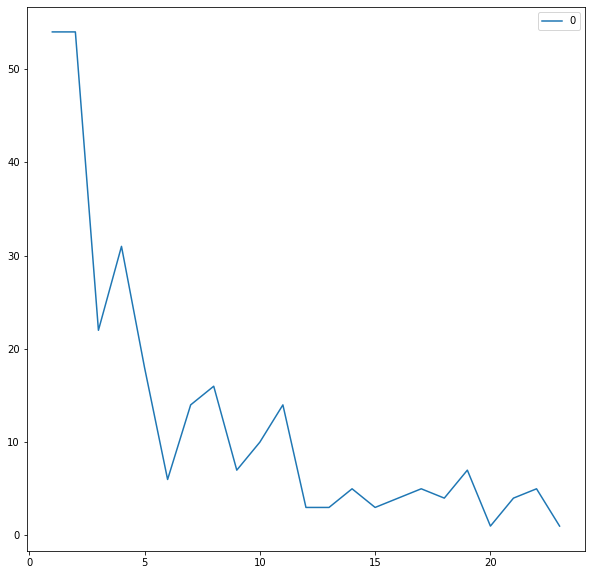

In [86]:
from collections import Counter
count = Counter(map_pkg(df, mf_ms)[0])
df_freq_freq = pd.DataFrame.from_dict(count, orient='index')
df_freq_freq.plot(kind='line')

### Packaging structure of past builds

In [55]:
with open('./parsed/prior_builds_metadata.json') as f:
    prior_builds_metadata = json.load(f)
len(prior_builds_metadata[2])

65

In [56]:
median_f_m = pd.DataFrame(map_pkg(df, mf_ms)[0])[0].quantile(interpolation='lower')
median_s_m = pd.DataFrame(map_pkg(df, mf_ms)[1])[0].quantile(interpolation='lower')
#print("f:", median_f_m, "s:", median_s_m)

def create_bins(arr, bins):
    freq_arr, size_arr, name_arr = arr
    if len(name_arr) == 0:
        return bins
    max_size = max(size_arr)
    bin_size = 0
    bin_content = []
    start = 0
    for i, _freq_pkg in enumerate(freq_arr):
        size_pkg = size_arr[i]
        bin_content.append(name_arr[i])
        bin_size += size_pkg
        
        if bin_size > max_size:
            bin_content.pop()
            bins.append({
                "content" : bin_content.copy(),
                "size" : bin_size - size_pkg,
                "freq_diff" : maxmin(freq_arr[start: i+1]),
                "size_diff" : maxmin(size_arr[start: i+1]),
            })
            bin_content.clear()
            bin_content.append(name_arr[i])
            bin_size = size_pkg
            start = i
        
        elif bin_size == max_size:
            bins.append({
                "content" : bin_content.copy(),
                "size" : bin_size,
                "freq_diff" : maxmin(freq_arr[start: i+1]),
                "size_diff" : maxmin(size_arr[start: i+1]),
            })
            bin_size = 0
            bin_content.clear()
            start = i + 1
            
        if i == len(freq_arr) - 1 and len(bin_content) != 0:
            bins.append({
            "content" : bin_content.copy(),
            "size" : bin_size,
            "freq_diff" : maxmin(freq_arr[start: i+1]),
            "size_diff" : maxmin(size_arr[start: i+1]),
            })
        
    return bins

bins = []
create_bins(map_pkg(df, hf_ls), bins)
create_bins(map_pkg(df, mf_ls), bins)
create_bins(map_pkg(df, lf_ls), bins)
create_bins(map_pkg(df, hf_ms), bins)
create_bins(map_pkg(df, mf_ms), bins)
create_bins(map_pkg(df, lf_ms), bins)
create_bins(map_pkg(df, hf_hs), bins)
create_bins(map_pkg(df, mf_hs), bins)
create_bins(map_pkg(df, lf_hs), bins)
print("Total bins formed: ", len(bins))
pkgs_bin = 0
for each_bin in bins:
    pkgs_bin += len(each_bin["content"])
print("Total pkgs in bins formed: ", pkgs_bin)

Total bins formed:  50
Total pkgs in bins formed:  451


Average of freq diff 1.18
Average of size diff 13482443.16


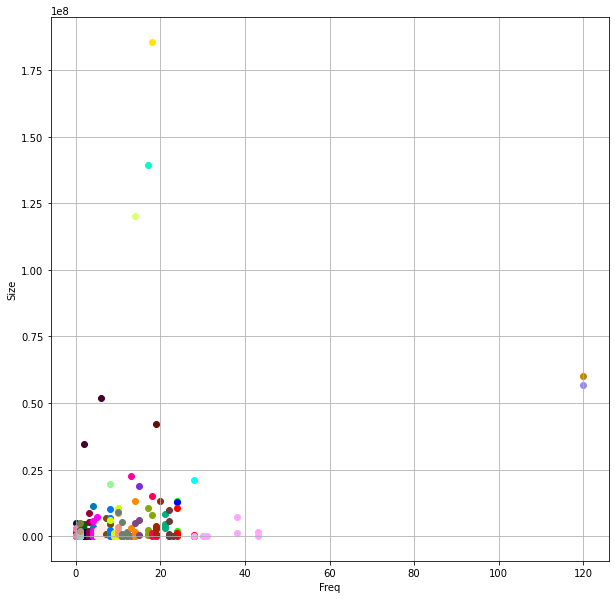

In [57]:
def plot_bins(bins):
    plt.ylabel("Size")
    plt.xlabel("Freq")  
    colors = ['#000000','#00FF00','#0000FF','#FF0000','#01FFFE','#FFA6FE','#FFDB66','#006401','#010067','#95003A','#007DB5','#FF00F6','#FFEEE8','#774D00','#90FB92','#0076FF','#D5FF00','#FF937E','#6A826C','#FF029D','#FE8900','#7A4782','#7E2DD2','#85A900','#FF0056','#A42400','#00AE7E','#683D3B','#BDC6FF','#263400','#BDD393','#00B917','#9E008E','#001544','#C28C9F','#FF74A3','#01D0FF','#004754','#E56FFE','#788231','#0E4CA1','#91D0CB','#BE9970','#968AE8','#BB8800','#43002C','#DEFF74','#00FFC6','#FFE502','#620E00','#008F9C','#98FF52','#7544B1','#B500FF','#00FF78','#FF6E41','#005F39','#6B6882','#5FAD4E','#A75740','#A5FFD2','#FFB167','#009BFF','#E85EBE',]
    for i, each_bin in enumerate(bins):
        plt.scatter(map_pkg(df, each_bin["content"])[0], map_pkg(df, each_bin["content"])[1], color=colors[i])
    plt.grid()

plot_bins(bins)
freq_maxmin = []
size_maxmin = []
for each_bin in bins:
    freq_maxmin.append(each_bin["freq_diff"])
    size_maxmin.append(each_bin["size_diff"])    
print("Average of freq diff", sum(freq_maxmin)/ len(freq_maxmin))
print("Average of size diff", sum(size_maxmin)/ len(size_maxmin))

In [94]:
def basic_packing(components, bins):
    bins = []
    # remove high freq anomaly and pack them as a bin
    # define max bin size to max(components.size)
    # Aim to minimize frequency maxmin(bin)
    # get freq/size (LHM) 9 parts
    # for the part with size>Max_SIZE and freq>max_min, recursively find median (0.5 quntile) of freqequncy
    # and use that as a partition to split the pkgs according to frequqncy. When once found fb<bands<fa, add
    # to bin by first size
    # Prevent doing a package structure change
    return